In [1]:
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read Dataset

,No,Mangosteen Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
0,6,99.95,0.895,4,6,184.490000,42.64,19.250,1
1,15,76.33,0.915,4,5,175.850000,45.68,22.500,1
2,24,51.48,0.968,4,6,130.276327,72.98,22.375,1
3,65,56.30,0.964,4,6,172.220000,38.54,18.000,1
4,122,59.72,0.928,4,6,97.220000,31.10,20.250,1
...,...,...,...,...,...,...,...,...,...
71,142,56.18,0.976,4,6,96.460000,28.26,16.375,0
72,74,60.12,0.973,4,6,174.010000,53.75,16.000,0
73,87,68.10,0.961,4,5,123.320000,21.03,17.125,0
74,101,56.80,0.958,4,6,75.440000,14.61,17.000,0


(76, 9)
0    44
1    32
Name: Class, dtype: int64


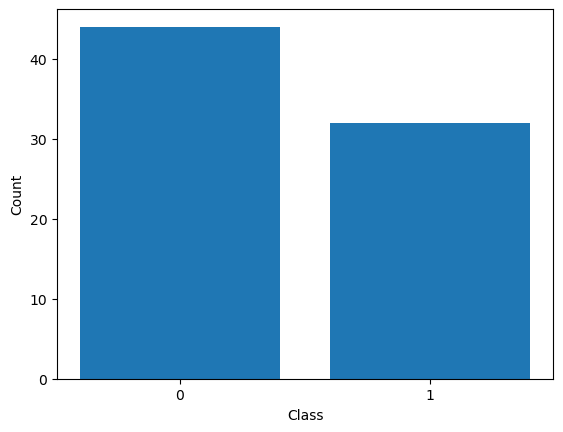

In [2]:
dataset = 'GoodDataset-1.csv'

if dataset == 'Dataset.xlsx':
    num = 0
    df = pd.read_excel(f'Dataset/{dataset}')
else:
    file = dataset.split('-')[0]
    num = dataset.split('-')[1].split('.')[0]
    df = pd.read_csv(f'Dataset/{dataset}')

# with pd.option_context('display.max_rows', 6): display(df)

display(df)

print(df.shape)

class_count = df['Class'].value_counts()
print(class_count)

plt.bar(['0', '1'], [class_count[0], class_count[1]])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Fill NaN with Mean

In [3]:
roundness_mean = df['Roundness'].mean()
max_frequency_mean = df['Max Frequency (Hz)'].mean()

print(f'Roundness Mean: {roundness_mean}')
print(f'Max Frequency (Hz) Mean: {max_frequency_mean}')

df['Roundness'].fillna(roundness_mean, inplace=True)
df['Max Frequency (Hz)'].fillna(max_frequency_mean, inplace=True)

Roundness Mean: 0.9453984480431847
Max Frequency (Hz) Mean: 128.54269602577872


# Features Selection

<Axes: >

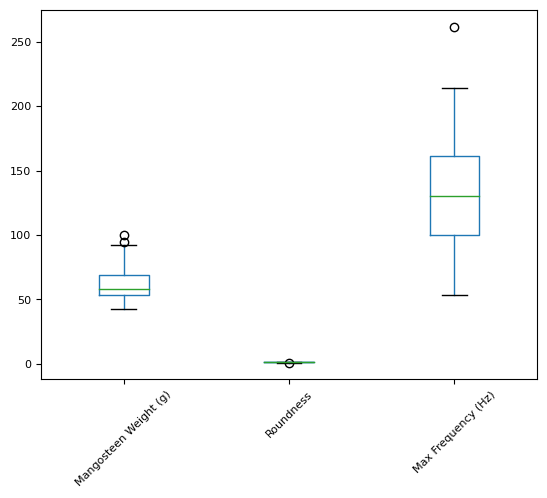

In [4]:
feature = ['Mangosteen Weight (g)', 'Roundness', 'Max Frequency (Hz)']
X = df[feature]
y = df['Class']

display(df.boxplot(column=feature, grid=False, rot=45, fontsize=8))

# Data Visualization

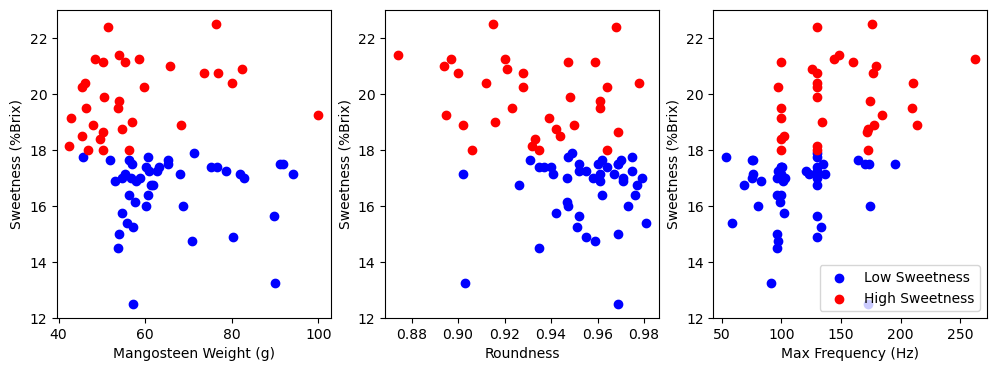

In [5]:
class_0 = df[y == 0]
class_1 = df[y == 1]

label = ['Mangosteen Weight (g)', 'Roundness', 'Max Frequency (Hz)']

figure, axis = plt.subplots(ncols=3, figsize=(12, 4))

for i, each in enumerate(label):
    axis[i].set_xlabel(each)
    axis[i].set_ylabel('Sweetness (%Brix)')
    
    axis[i].scatter(class_0[each], class_0['Sweetness (%Brix)'], color='b', label='Low Sweetness')
    axis[i].scatter(class_1[each], class_1['Sweetness (%Brix)'], color='r', label='High Sweetness')

plt.legend(loc='best')
plt.show()

# Hyperparameter

In [6]:
cross_validation = KFold(n_splits=10, shuffle=True, random_state=42)

## KNN

In [7]:
standard_scaler = StandardScaler()

KNN = neighbors.KNeighborsClassifier(n_jobs=-1)
KNN_parameter = {
    'model__leaf_size': list(range(1, 15)),
    'model__n_neighbors': list(range(1, 10, 2)),
    'model__p': [1.0, 1.2, 2.0, 2.1, 3.0],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', KNN)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=KNN_parameter, 
                           cv=cross_validation, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('KNN Best Estimator: ', grid_search.best_estimator_)
print('KNN Best Parameter: ', grid_search.best_params_)
print('KNN Best Score: ', grid_search.best_score_)

KNN Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1,
                                      p=3.0))])
KNN Best Parameter:  {'model__algorithm': 'auto', 'model__leaf_size': 1, 'model__n_neighbors': 1, 'model__p': 3.0, 'model__weights': 'uniform'}
KNN Best Score:  0.9607142857142857


## SVM

In [8]:
standard_scaler = StandardScaler()

SVM = SVC()
SVM_parameter = [
    {'model__kernel': ['linear'], 'model__C': [1.0, 1.4, 1.8, 2.0, 2.4, 2.8, 3.0]},
    {'model__kernel': ['rbf'], 'model__C': [1.0, 1.4, 1.8, 2.0, 2.4, 2.8, 3.0], 'model__gamma': [1.0, 2.0, 3.0, 4.0]}
]

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', SVM)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=SVM_parameter, 
                           cv=cross_validation, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('SVM Best Estimator: ', grid_search.best_estimator_)
print('SVM Best Parameter: ', grid_search.best_params_)
print('SVM Best Score: ', grid_search.best_score_)

SVM Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', SVC(C=1.8, gamma=1.0))])
SVM Best Parameter:  {'model__C': 1.8, 'model__gamma': 1.0, 'model__kernel': 'rbf'}
SVM Best Score:  0.9607142857142857


## Logistic Regression

In [9]:
standard_scaler = StandardScaler()

LR = LogisticRegression()
LR_parameter = [
    {'model__solver': ['newton-cg', 'lbfgs', 'sag'], 'model__penalty': ['l2']},
    {'model__solver': ['liblinear'], 'model__penalty': ['l1', 'l2']},
    {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', LR)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=LR_parameter, 
                           cv=cross_validation, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Logistic Regression Best Estimator: ', grid_search.best_estimator_)
print('Logistic Regression Best Parameter: ', grid_search.best_params_)
print('Logistic Regression Best Score: ', grid_search.best_score_)

Logistic Regression Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 LogisticRegression(penalty='l1', solver='liblinear'))])
Logistic Regression Best Parameter:  {'model__penalty': 'l1', 'model__solver': 'liblinear'}
Logistic Regression Best Score:  0.8696428571428572


## Decision Tree

In [10]:
standard_scaler = StandardScaler()

DT = DecisionTreeClassifier(criterion='entropy', random_state=42)
DT_parameter = {
    'model__max_depth': list(range(1, 15)),
    'model__max_leaf_nodes': list(range(2, 15))
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', DT)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=DT_parameter, 
                           cv=cross_validation, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Decision Tree Best Estimator: ', grid_search.best_estimator_)
print('Decision Tree Best Parameter: ', grid_search.best_params_)
print('Decision Tree Best Score: ', grid_search.best_score_)

Decision Tree Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        max_leaf_nodes=7, random_state=42))])
Decision Tree Best Parameter:  {'model__max_depth': 4, 'model__max_leaf_nodes': 7}
Decision Tree Best Score:  0.9107142857142858


## XGBoost

In [11]:
standard_scaler = StandardScaler()

XGBoost = XGBClassifier(learning_rate=0.02, objective='binary:logistic', nthread=1)
XGBoost_parameter = {
    'model__min_child_weight': list(range(1, 5)),
    'model__gamma': list(range(1, 3)),
    'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__n_estimators': [500, 1000],
    'model__max_depth': list(range(1, 5))
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', XGBoost)])

grid_search = GridSearchCV(estimator=pipeline, param_grid=XGBoost_parameter, cv=cross_validation, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X, y)

print('XGBoost Best Estimator: ', grid_search.best_estimator_)
print('XGBoost Best Parameter: ', grid_search.best_params_)
print('XGBoost Best Score: ', grid_search.best_score_)

XGBoost Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=1000, n_jobs=Non

## LightGBM

In [12]:
standard_scaler = StandardScaler()

LightGBM = LGBMClassifier(learning_rate=0.02, objective='binary', n_jobs=-1, random_state=42)
LightGBM_parameter = {
    'model__num_leaves': list(range(2, 5)),
    'model__max_depth': list(range(1, 4)),
    'model__n_estimators': [500, 1000],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', LightGBM)])

grid_search = GridSearchCV(estimator=pipeline, param_grid=LightGBM_parameter, cv=cross_validation, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X, y)

print('LightGBM Best Estimator: ', grid_search.best_estimator_)
print('LightGBM Best Parameter: ', grid_search.best_params_)
print('LightGBM Best Score: ', grid_search.best_score_)

LightGBM Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(learning_rate=0.02, max_depth=2,
                                n_estimators=1000, num_leaves=3,
                                objective='binary', random_state=42))])
LightGBM Best Parameter:  {'model__colsample_bytree': 1.0, 'model__max_depth': 2, 'model__n_estimators': 1000, 'model__num_leaves': 3}
LightGBM Best Score:  0.9625


## Neural Network

In [13]:
standard_scaler = StandardScaler()

NN = MLPClassifier(max_iter=50000, random_state=42)
NN_parameter = {
    'model__hidden_layer_sizes': [(2, 2), (3, 4), (4, 2), (4, 4)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['lbfgs', 'sgd', 'adam']
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', NN)])

grid_search = GridSearchCV(estimator=pipeline, param_grid=NN_parameter, cv=cross_validation, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X, y)

print('Neural Network Best Estimator: ', grid_search.best_estimator_)
print('Neural Network Best Parameter: ', grid_search.best_params_)
print('Neural Network Best Score: ', grid_search.best_score_)

Neural Network Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(2, 2),
                               max_iter=50000, random_state=42,
                               solver='lbfgs'))])
Neural Network Best Parameter:  {'model__activation': 'tanh', 'model__hidden_layer_sizes': (2, 2), 'model__solver': 'lbfgs'}
Neural Network Best Score:  0.9625


## Random Forest

In [14]:
standard_scaler = StandardScaler()

RandomForest = RandomForestClassifier(criterion='gini', random_state=42)
RandomForest_parameter = {
    'model__n_estimators': list(range(1, 30)),
    'model__max_depth': list(range(1, 15)),
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', RandomForest)])

grid_search = GridSearchCV(estimator=pipeline, param_grid=RandomForest_parameter, cv=cross_validation, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X, y)

print('RandomForest Best Estimator: ', grid_search.best_estimator_)
print('RandomForest Best Parameter: ', grid_search.best_params_)
print('RandomForest Best Score: ', grid_search.best_score_)

print('------------')

RandomForest = RandomForestClassifier(max_depth=5, 
                                      n_estimators=15, 
                                      criterion='gini', 
                                      random_state=42)

RandomForest Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=4,
                                        random_state=42))])
RandomForest Best Parameter:  {'model__max_depth': 5, 'model__n_estimators': 4}
RandomForest Best Score:  0.9357142857142857
------------


# Model Initialization

In [15]:
KNN = neighbors.KNeighborsClassifier(algorithm='auto',
                                     leaf_size=1,
                                     n_neighbors=1, 
                                     p=3, 
                                     weights='uniform')

SVM = SVC(C=1.0, 
          gamma=1.0, 
          kernel='rbf', 
          probability=True)

LR = LogisticRegression(C=0.1)

DT = DecisionTreeClassifier(max_depth=4, 
                            max_leaf_nodes=7,
                            criterion='entropy', 
                            random_state=42)

XGBoost = XGBClassifier(colsample_bytree=0.8, 
                        gamma=1.0, 
                        max_depth=2, 
                        min_child_weight=2, 
                        n_estimators=500, 
                        subsample=0.8, 
                        learning_rate=0.02, 
                        objective='binary:logistic', 
                        nthread=1)

LightGBM = LGBMClassifier(colsample_bytree=1.0, 
                          max_depth=2, 
                          n_estimators=1000,
                          num_leaves=3,
                          learning_rate=0.02, 
                          objective='binary', 
                          n_jobs=-1, 
                          random_state=42)

NN = MLPClassifier(activation='tanh', 
                   hidden_layer_sizes=(4, 4), 
                   solver='adam',
                   max_iter=50000, 
                   random_state=42)

RandomForest = RandomForestClassifier(max_depth=3, 
                                      n_estimators=24, 
                                      criterion='gini', 
                                      random_state=42)

estimator = [
    ('KNN', KNN),
    ('SVM', SVM),
    ('LR', LR),
    ('DT', DT),
    ('XGBoost', XGBoost),
    ('LightGBM', LightGBM),
    ('NN', NN),
    ('RandomForest', RandomForest)
]
Voting = VotingClassifier(estimator, weights=[0.15, 0.1, 0.05, 0.1, 0.3, 0.1, 0.1, 0.1], voting='soft', n_jobs=-1)

# Train Model and Cross-validation

In [16]:
model_y_true = {
    'index': [],
    'no': [],
    'y_true': []
}
model_y_predict = {
    'KNN': [],
    'SVM': [],
    'LR': [],
    'DT': [],
    'XGBoost': [],
    'LightGBM': [],
    'NN': [],
    'RandomForest': [],
    'Voting': []
}
model_y_predict_score = {
    'KNN': [],
    'SVM': [],
    'LR': [],
    'DT': [],
    'XGBoost': [],
    'LightGBM': [],
    'NN': [],
    'RandomForest': [],
    'Voting': []
}

classifier = [
    ('KNN', KNN),
    ('SVM', SVM),
    ('LR', LR),
    ('DT', DT),
    ('XGBoost', XGBoost),
    ('LightGBM', LightGBM),
    ('NN', NN),
    ('RandomForest', RandomForest),
    ('Voting', Voting)
]

KNN Average Accuracy:  0.9605263157894737
SVM Average Accuracy:  0.8947368421052632
LR Average Accuracy:  0.8552631578947368
DT Average Accuracy:  0.9078947368421053
XGBoost Average Accuracy:  0.9473684210526315
LightGBM Average Accuracy:  0.9605263157894737
NN Average Accuracy:  0.9342105263157895
RandomForest Average Accuracy:  0.881578947368421
Voting Average Accuracy:  0.9736842105263158


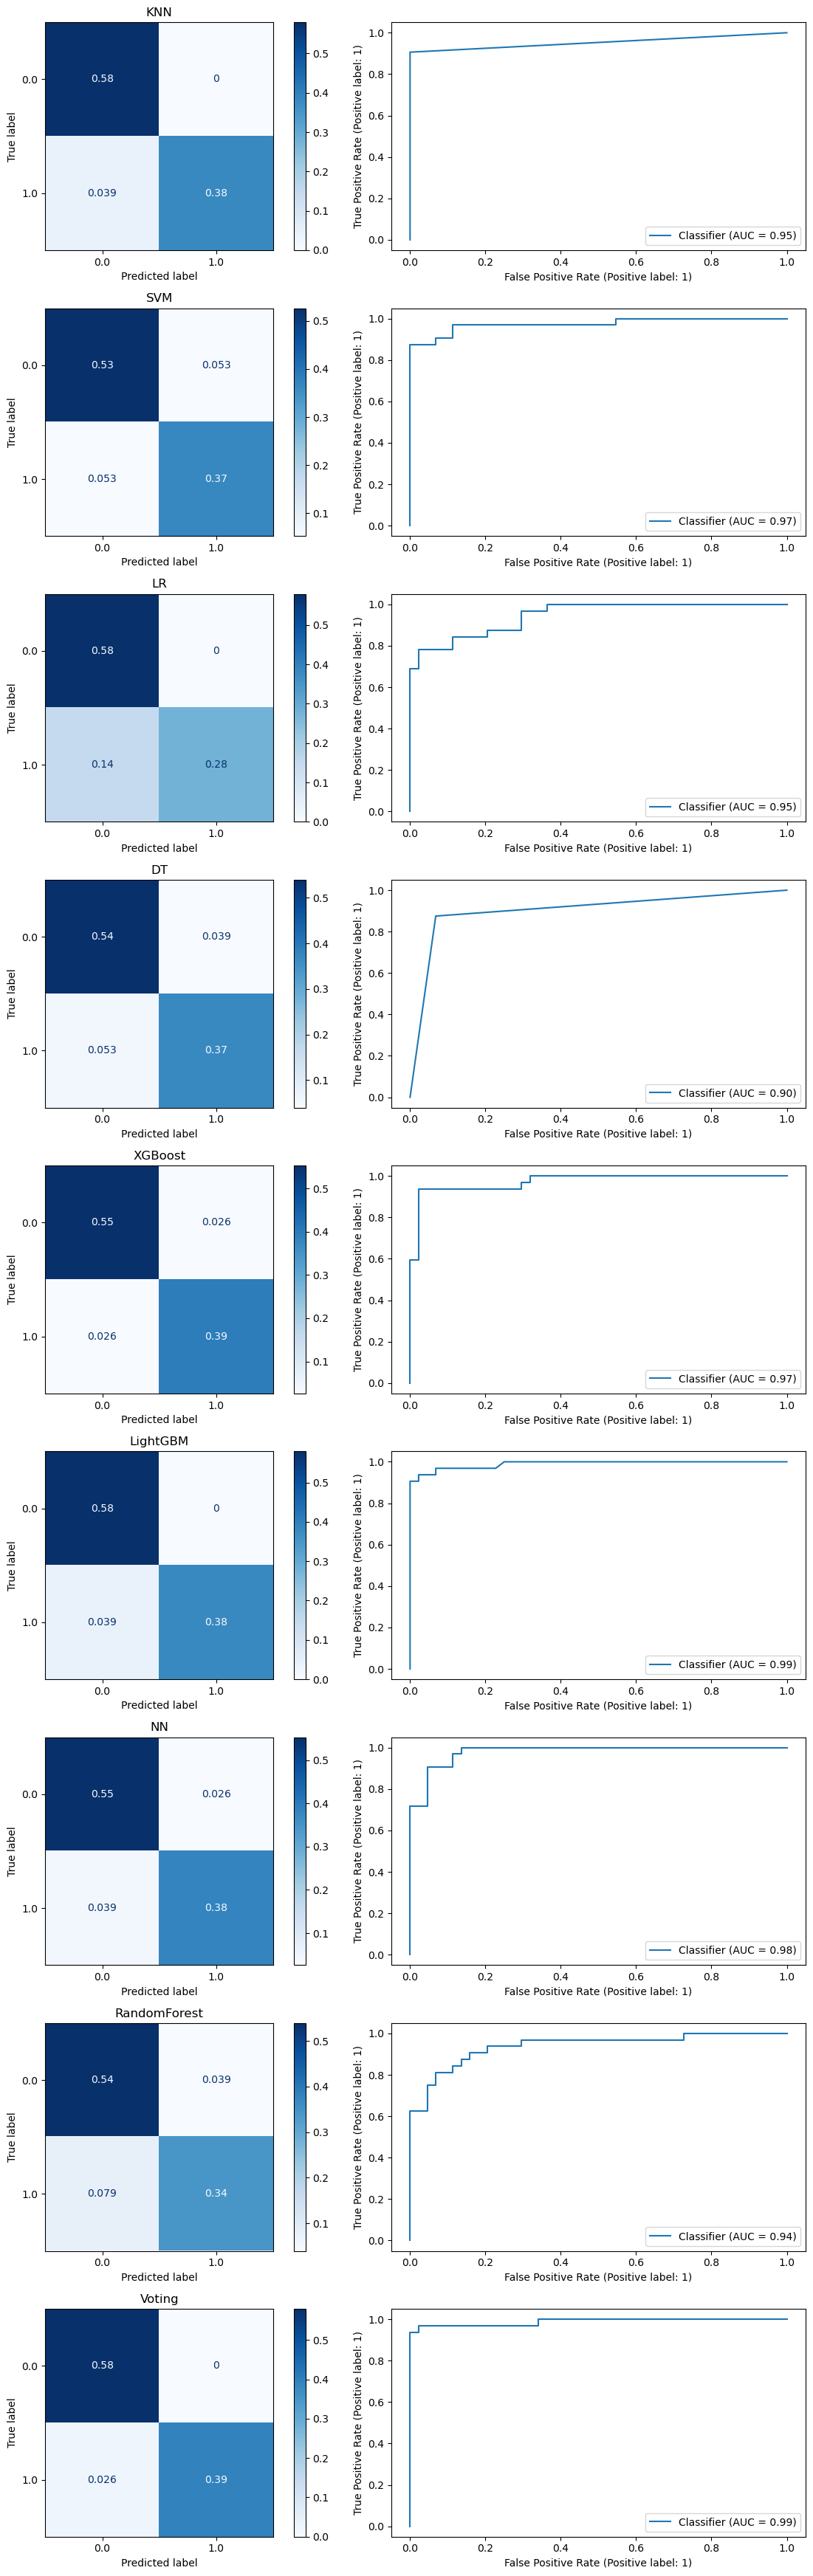

In [17]:
for train_index, test_index in cross_validation.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    model_y_true['index'] = np.append(model_y_true['index'], test_index)
    model_y_true['no'] = np.append(model_y_true['no'], df.iloc[test_index, 0])
    model_y_true['y_true'] = np.append(model_y_true['y_true'], y_test)

    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test)

    for label, model in classifier:
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        y_predict_score = model.predict_proba(X_test)
        model_y_predict[label] = np.append(model_y_predict[label], y_predict)
        model_y_predict_score[label] = np.append(model_y_predict_score[label], y_predict_score[:, 1])

for label in model_y_predict:
    print(f'{label} Average Accuracy: ', accuracy_score(model_y_true['y_true'], model_y_predict[label]))

figure, axis = plt.subplots(nrows=9, ncols=2, figsize=(12, 35))

for i, label in enumerate(model_y_predict):
    axis[i, 0].set_title(label)
    ConfusionMatrixDisplay.from_predictions(model_y_true['y_true'], model_y_predict[label], ax=axis[i][0], cmap=plt.cm.Blues, normalize='all')
    RocCurveDisplay.from_predictions(model_y_true['y_true'], model_y_predict_score[label], ax=axis[i][1])
    
figure.tight_layout()
plt.show()

# Prediction on Dataset

## True Prediction

In [18]:
count_prediction = pd.DataFrame({'index': model_y_true['index'],
                                 'no': model_y_true['no'],
                                 'y_true': model_y_true['y_true']})

for label in model_y_predict:
    count_prediction[label] = model_y_predict[label]

count_prediction['Prediction Rate'] = count_prediction.iloc[:, 3:].sum(axis=1) / len(classifier)

# display(count_prediction)

positive_prediction = count_prediction[count_prediction['Prediction Rate'] >= 0.5]
true_positive_prediction = positive_prediction[positive_prediction['y_true'] == 1]

# display(true_positive_prediction)

negative_prediction = count_prediction[count_prediction['Prediction Rate'] < 0.5]
true_negative_prediction = negative_prediction[negative_prediction['y_true'] == 0]

# display(false_negative_prediction)

true_prediction = pd.concat([true_positive_prediction, true_negative_prediction])

display(true_prediction)

print('Shape: ', true_prediction.shape)

true_prediction.to_csv(f'TruePrediction-{int(num) + 1}.csv')

,index,no,y_true,KNN,SVM,LR,DT,XGBoost,LightGBM,NN,RandomForest,Voting,Prediction Rate
0,0.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,10.0,148.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,12.0,117.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,18.0,25.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,28.0,27.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,59.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,66.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,51.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,60.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shape:  (74, 13)


In [19]:
good_dataset = df.loc[true_prediction['index'].tolist(), :]

display(good_dataset)

good_dataset.to_csv(f'GoodDataset-{int(num) + 1}.csv', index=False)

,No,Mangosteen Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
0,6,99.95,0.895,4,6,184.490000,42.64,19.250,1
10,148,45.46,0.944,4,4,102.050000,47.16,18.500,1
12,117,46.69,0.935,4,6,130.276327,18.86,18.000,1
18,25,50.21,0.906,4,6,99.700000,66.54,18.000,1
28,27,65.77,0.894,4,6,179.250000,80.30,21.000,1
...,...,...,...,...,...,...,...,...,...
59,138,54.60,0.979,4,6,96.700000,37.37,17.000,0
66,79,57.04,0.969,4,5,169.970000,24.89,17.500,0
51,54,80.19,0.955,4,6,130.276327,62.87,14.875,0
60,150,53.95,0.969,4,5,96.700000,33.08,15.000,0


## False Prediction

In [20]:
positive_prediction = count_prediction[count_prediction['Prediction Rate'] >= 0.5]
false_positive_prediction = positive_prediction[positive_prediction['y_true'] == 0]

# display(true_positive_prediction)

negative_prediction = count_prediction[count_prediction['Prediction Rate'] < 0.5]
false_negative_prediction = negative_prediction[negative_prediction['y_true'] == 1]

# display(false_negative_prediction)

false_prediction = pd.concat([false_positive_prediction, false_negative_prediction])

display(false_prediction)

print('Shape: ', false_prediction.shape)

false_prediction.to_csv(f'FalsePrediction-{int(num) + 1}.csv')

,index,no,y_true,KNN,SVM,LR,DT,XGBoost,LightGBM,NN,RandomForest,Voting,Prediction Rate
1,4.0,122.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
32,3.0,65.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111


Shape:  (2, 13)


In [21]:
bad_dataset = df.loc[false_prediction['index'].tolist(), :]

display(bad_dataset)

bad_dataset.to_csv(f'BadDataset-{int(num) + 1}.csv', index=False)

,No,Mangosteen Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
4,122,59.72,0.928,4,6,97.22,31.10,20.25,1
3,65,56.30,0.964,4,6,172.22,38.54,18.00,1
